# Section 2a: Comparing model summary statistics

In [1]:
library(tidyverse)
library(GGally)
library(ggpubr)
library(patchwork)
library(ggrepel)
library(data.table)
library(scales)
library(Gviz)

absmax = function(x) { x[which.max( abs(x) )]}

setwd("~/work/mpra-v2/")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGen

In [2]:
love = fread("sumstats/1KG_novaSeq_DESeq2_Love_Base2.txt", header = T)

love = subset(love, haploFlag == "Base")
love$pos = as.character(love$pos)

In [4]:
tewhey = fread("annotation/Tewhey-stats.txt")
tewhey.hits = tewhey[which(tewhey$C.Skew.fdr > 1.3 & tewhey$Haplotype == "ref"),]

rsid = fread("annotation/Tewhey-rsID-convert.txt", drop = 2)
names(rsid) = c("chrom","pos","SNP")

tewhey.rsid = merge(tewhey.hits, rsid, by = "SNP")
tewhey.rsid$pos = as.character(tewhey.rsid$pos)

tewhey.all = merge(tewhey, rsid, by = "SNP")
tewhey.all$pos = as.character(tewhey.all$pos)

In [5]:
love$inTewhey = ifelse(interaction(love[,c("chrom","pos")]) %in% interaction(tewhey.rsid[,c("chrom","pos")]),
                       "yes","no")

love$Pool[which(love$Pool == "Sabeti" & love$inTewhey == "no")] = "1KGTest"
love$Pool[which(love$Pool != "Sabeti" & love$inTewhey == "yes")] = "Sabeti"

love$strand = ifelse(love$strand == "+","pos","neg")

`summarise()` ungrouping output (override with `.groups` argument)



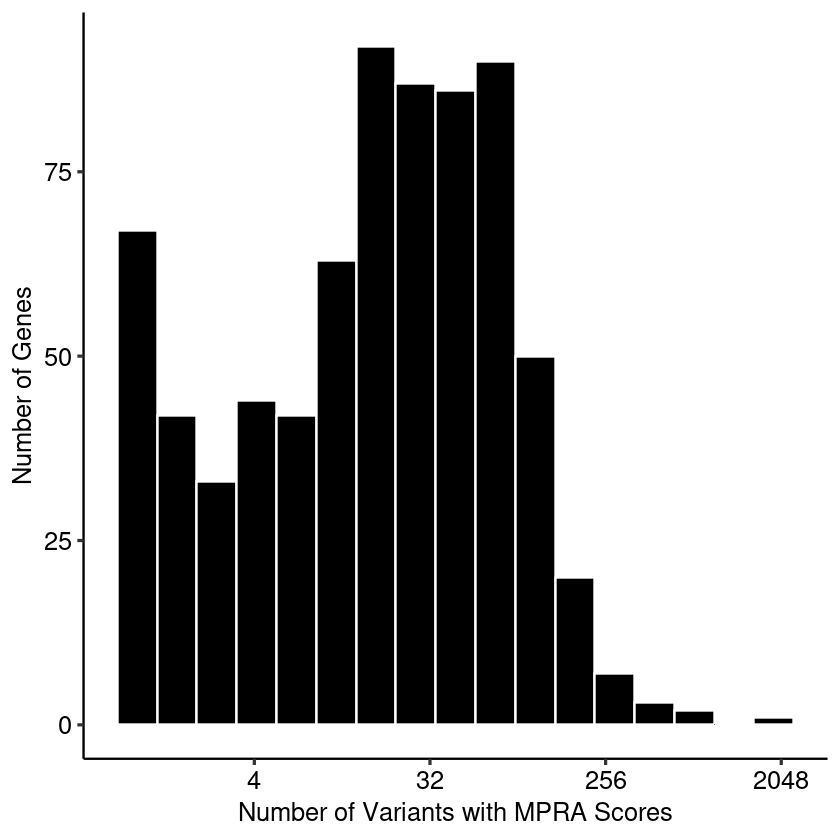

In [5]:
options(repr.plot.width = 7, repr.plot.height= 7)
separate_rows(love, geneID, sep=",") %>% group_by(geneID) %>% summarize("count" = n()) %>% 
    ggplot() + 
        geom_histogram(aes(x = count), bins = 17, color = "white", fill = "black") + 
        theme_pubr(base_size = 15) + 
        scale_x_continuous(trans = "log2") + xlab("Number of Variants with MPRA Scores") + ylab("Number of Genes")

Warning message:
"Duplicated aesthetics after name standardisation: linetype"
Warning message:
"Duplicated aesthetics after name standardisation: linetype"


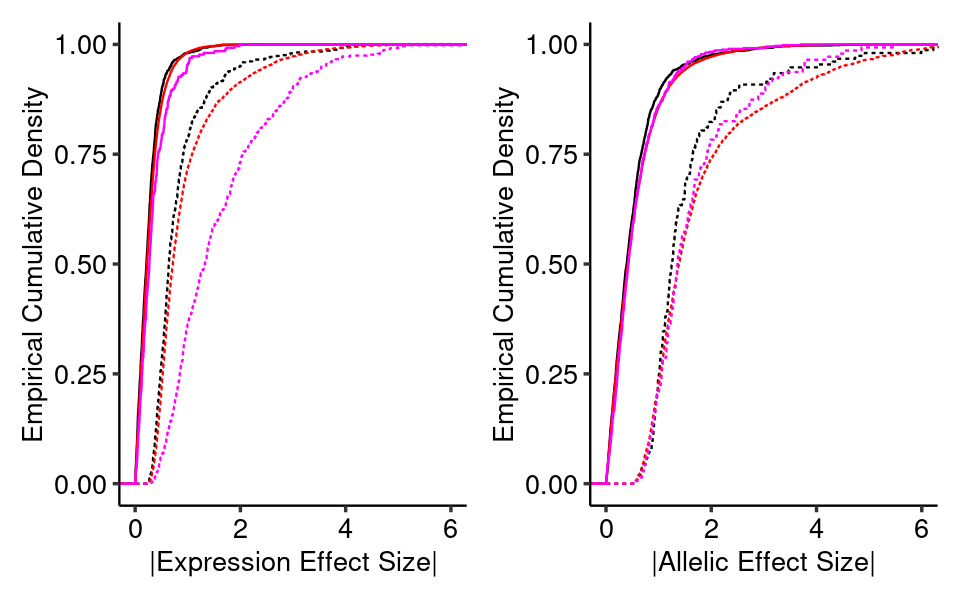

In [6]:
groupDens = ggplot(love) +
                stat_ecdf(aes(x = abs(log2FoldChange_expr),
                              color = Pool,
                              linetype=ifelse(padj_expr<5e-2,"A","B"),
                              lty=ifelse(padj_expr<5e-2,0,14))) + 
                scale_linetype_manual(values = c("A"= "44" , "B" = "solid"))+
                theme_pubr(base_size = 16) +
                coord_cartesian(xlim=c(0,6))+
                scale_color_manual(values = c("1KGTest" = "red","1KGControl"= "black", "Sabeti" = "magenta")) +
                theme(legend.position = "none") +
                xlab("|Expression Effect Size|") + ylab("Empirical Cumulative Density")

groupDens2 = ggplot(love) +
                stat_ecdf(aes(x = abs(log2FoldChange_allele),
                              color = Pool,
                              linetype=ifelse(padj_allele<5e-2,"A","B"),
                              lty=ifelse(padj_allele<5e-2,0,14))) + 
                scale_linetype_manual(values = c("A"= "44" , "B" = "solid"))+
                theme_pubr(base_size = 16) +
                coord_cartesian(xlim=c(0,6))+
                scale_color_manual(values = c("1KGTest" = "red","1KGControl"= "black", "Sabeti"  = "magenta")) +
                theme(legend.position = "noen") +
                xlab("|Allelic Effect Size|") + ylab("Empirical Cumulative Density")

options(repr.plot.width=8, repr.plot.height=5)
groupDens + groupDens2

In [6]:
ggd.qqplot_ci = function(xsList, ci=0.95, Main=NULL) {
    cbp1 = c("#E69F00", "#56B4E9", "#009E73","#F0E442", "#0072B2", "#D55E00", "#CC79A7")
    p = ggplot() + 
            geom_abline(intercept=0, slope=1, alpha=0.5) + 
            ggtitle(Main) + 
            theme(plot.title = element_text(hjust = 0.5))
    labels = names(xsList)
    colLabels = c()
    for(i in seq(1,length(xsList),1)){
        xs = xsList[[i]]
        label = labels[i]
        N = length(xs)
        df = data.frame(observed=-log10(sort(xs)), 
                        expected=-log10(1:N / N), 
                        cupper=-log10(qbeta(ci, 1:N, N - 1:N + 1)),
                        clower=-log10(qbeta(1 - ci, 1:N, N - 1:N + 1)))
        p = p + geom_point(data = df, aes(expected, observed),
                           color = cbp1[i],
                           shape=19,
                           size=3)
        colLabels = c(colLabels,label)
        names(colLabels)[i] = cbp1[i]
        }
    p = p + scale_color_manual(values=colLabels, guide="legend")
    return(p)
}

In [18]:
pC = ggd.qqplot_ci(list("tewhey" = subset(love, Pool == "Sabeti" , select = pvalue_expr)$pvalue_expr,
                   "test" = subset(love, Pool == "1KGTest" , select = pvalue_expr)$pvalue_expr,
                   "contrrol" = subset(love, Pool == "1KGControl" , select = pvalue_expr)$pvalue_expr)) +
    theme_pubr(base_size = 15) + coord_cartesian(clip = "off")

In [31]:
pD = ggd.qqplot_ci(list("tewhey" = subset(love, Pool == "Sabeti", select = pvalue_allele)$pvalue_allele,
                   "test" = subset(love, Pool == "1KGTest", select = pvalue_allele)$pvalue_allele,
                   "contrrol" = subset(love, Pool == "1KGControl" , select = pvalue_allele)$pvalue_allele)) + 
    ylim(c(0,35)) + xlim(c(0,5)) +
    theme_pubr(base_size = 15)

In [9]:
hitProps = data.frame("exprProps" = as.numeric(table(love$Pool[which(love$padj_expr < 5e-2)]) / table(love$Pool)),
                      "alleleProps" = as.numeric(table(love$Pool[which(love$padj_allele < 5e-2 )]) / table(love$Pool)))
hitProps$group = c("Non-eQTL","eQTL","Tewhey")
hitProps

exprProps,alleleProps,group
<dbl>,<dbl>,<chr>
0.2617271,0.08155650,Non-eQTL
0.2700602,0.08733343,eQTL
0.6465753,0.19589041,Tewhey


In [27]:
cbp1 = c("#E69F00", "#56B4E9", "#009E73","#F0E442", "#0072B2", "#D55E00", "#CC79A7")
colorList = cbp1[c(2,3,1)]
names(colorList) = hitProps$Pool

pC1 = ggplot(hitProps) + 
    geom_bar(aes(x = group, y = exprProps, fill = group),  stat = "identity") + 
    geom_text(aes(x = group, y = exprProps + 0.05, label = as.character(round(exprProps,digits = 2))), size = 6.5) + 
    scale_fill_manual(values = colorList) + labs(y = "Proportion of \nVariants with Effect") +
    theme_pubr(legend = "none", base_size = 18,x.text.angle = 45)  + 
    theme(axis.title.x = element_blank())

pD1 = ggplot(hitProps) + 
    geom_bar(aes(x = group, y = alleleProps, fill = group),  stat = "identity") + 
    geom_text(aes(x = group, y = alleleProps + 0.015, label = as.character(round(alleleProps,digits = 2))), size = 6.5) + 
    scale_fill_manual(values = colorList) + labs(y = "Proportion of \nVariants with Effect") +
    theme_pubr(legend = "none", base_size = 18,x.text.angle = 45)  + 
    theme(axis.title.x = element_blank())

Warning message:
"Removed 2 rows containing missing values (geom_point)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."


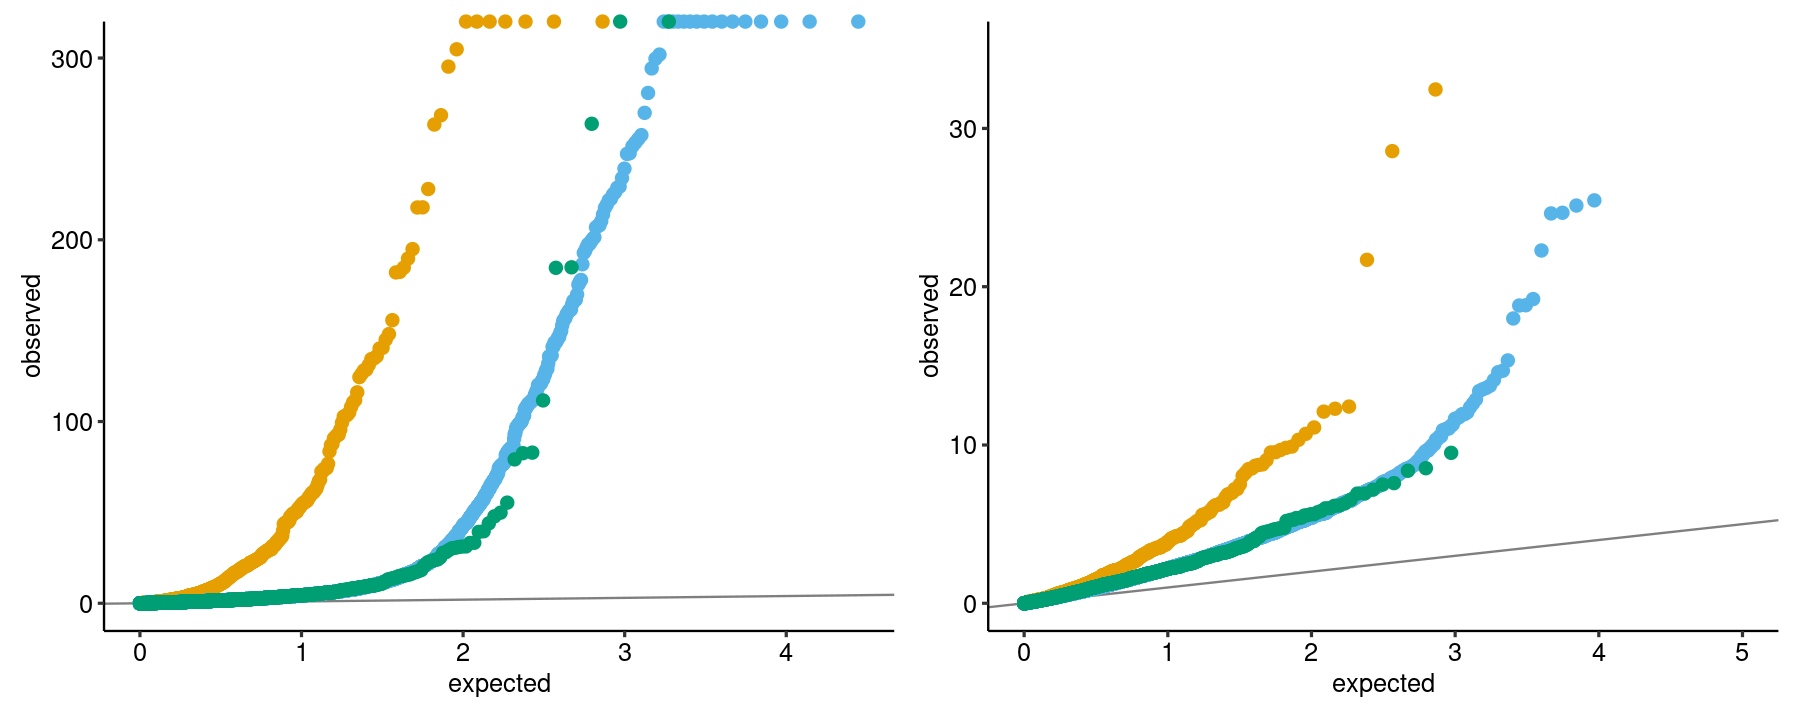

In [32]:
options(repr.plot.width = 15, repr.plot.height = 6)
pC + pD

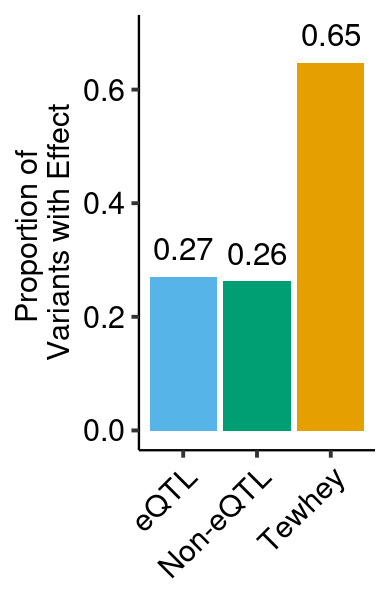

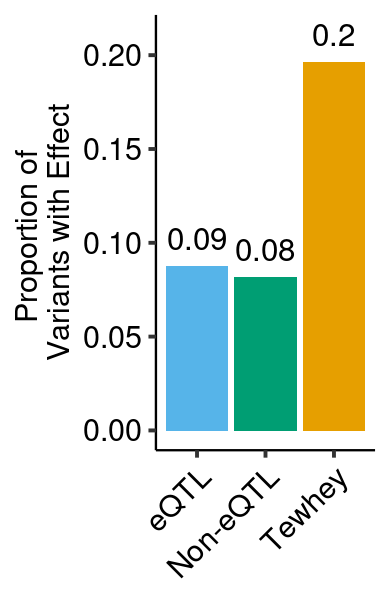

In [29]:
options(repr.plot.width = 3.25, repr.plot.height = 5)
pC1
pD1

In [23]:
loveTewhey = merge(love, tewhey.rsid, by.x = c("chrom","pos","strand"), by.y = c("chrom","pos","Direction"))
loveTewheyAll = merge(love, tewhey.all, by.x = c("chrom","pos","strand"), by.y = c("chrom","pos","Direction"))

loveTewheyAll$group = "Neither"
loveTewheyAll$group[which(loveTewheyAll$padj_allele < 5e-2 & loveTewheyAll$padj_expr < 5e-2)] = "Abell et al Only"
loveTewheyAll$group[which(loveTewheyAll$C.Skew.fdr > 1.3)] = "Tewhey et al Only"
loveTewheyAll$group[which(loveTewheyAll$padj_allele < 5e-2 & loveTewheyAll$padj_expr < 5e-2 & loveTewheyAll$C.Skew.fdr > 1.3)] = "Both"


`summarise()` ungrouping output (override with `.groups` argument)



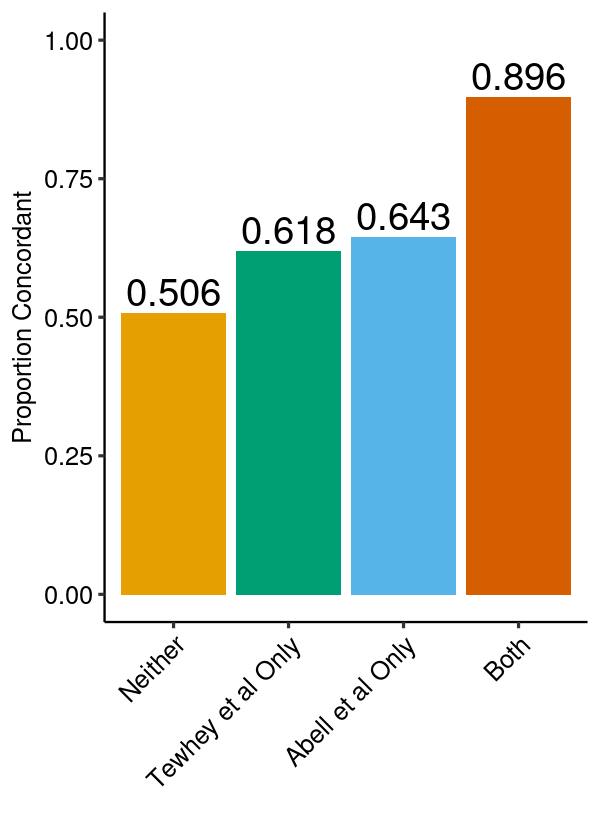

In [24]:
options(repr.plot.width = 5, repr.plot.height = 7)

loveTewheyAll %>% 
    group_by(group) %>% 
    summarize(prop = sum(sign(log2FoldChange_allele) == sign(LogSkew.Comb))/length(LogSkew.Comb)) %>%
    ggplot(aes(x = reorder(group, prop), y = prop, fill = group)) + 
    geom_bar(stat = "identity") + 
    geom_text(aes(y = prop + 0.04, label = round(prop, 3)), size = 8) +
    theme_pubr(base_size = 15, x.text.angle = 45) + 
    theme(legend.position = "none") +
    xlab("") + ylab("Proportion Concordant") + ylim(c(0,1)) +
    scale_fill_manual(values = c("Neither" = "#E69F00",
                                 "Abell et al Only" = "#56B4E9",
                                 "Tewhey et al Only" = "#009E73",
                                 "Both" = "#D55E00"))

Warning message:
"Removed 118 rows containing missing values (geom_point)."


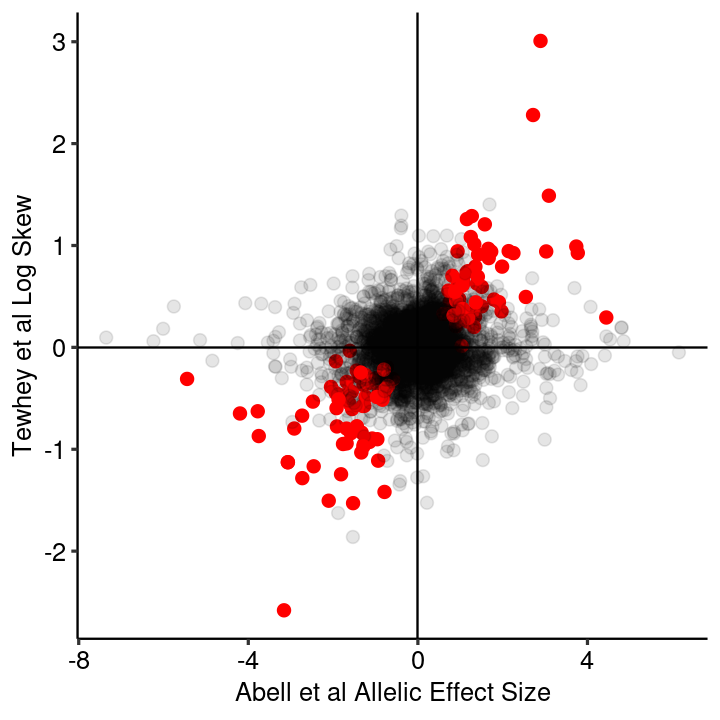

In [25]:
options(repr.plot.width = 6, repr.plot.height = 6)

ggplot(loveTewheyAll, aes(x = log2FoldChange_allele, y = LogSkew.Comb)) + 
    geom_point(aes(alpha = ifelse(padj_allele < 5e-2 &
                                  sign(LogSkew.Comb) == sign(log2FoldChange_allele) &
                                  C.Skew.fdr > 1.3,1,0.2),
                   color = ifelse(padj_allele < 5e-2 &
                                  sign(LogSkew.Comb) == sign(log2FoldChange_allele) &
                                  C.Skew.fdr > 1.3,"red","black")),
               size = 3) + 
    theme_pubr(base_size = 15) + 
    geom_hline(yintercept = 0) + geom_vline(xintercept = 0) + 
    xlab("Abell et al Allelic Effect Size") +
    ylab("Tewhey et al Log Skew") +
    scale_color_manual(values = c("red" = "red", "black" = "black")) +
    theme(legend.position = "none")

Warning message:
"Removed 2 rows containing missing values (geom_point)."


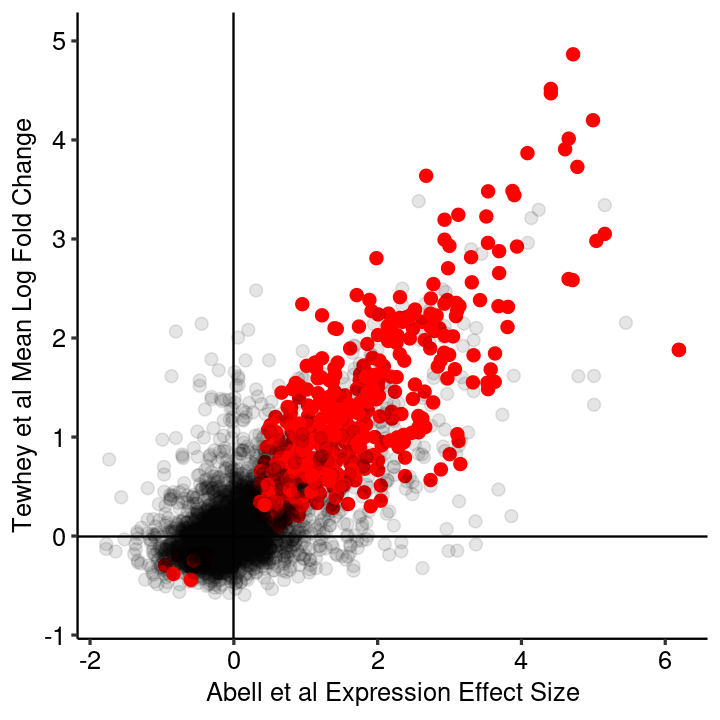

In [26]:
options(repr.plot.width = 6, repr.plot.height = 6)

loveTewheyAll$inList = "no"
loveTewheyAll$inList[which(loveTewheyAll$padj_expr < 5e-2 &
                           loveTewheyAll$C.Skew.fdr > 1.3 &
                           sign(loveTewheyAll$log2FoldChange_expr) == sign(loveTewheyAll$C.A.log2FC + loveTewheyAll$C.B.log2FC)  &
                           abs( ((loveTewheyAll$C.A.log2FC + loveTewheyAll$C.B.log2FC)/2) - loveTewheyAll$log2FoldChange_expr) < 1.32)] = "yes"

loveTewheyAll$inList[which(loveTewheyAll$padj_expr < 5e-2 &
                           loveTewheyAll$C.Skew.fdr > 1.3 &
                           sign(loveTewheyAll$log2FoldChange_expr) == sign(loveTewheyAll$C.A.log2FC + loveTewheyAll$C.B.log2FC))] = "yes"

ggplot(loveTewheyAll,
       aes(x = log2FoldChange_expr,
           y = (C.A.log2FC + C.B.log2FC)/2)) + 
    geom_point(aes(alpha = ifelse(inList == "yes", 1,0.2),
                   color = ifelse(inList == "yes", "red","black")),
               size = 3) + 
    theme_pubr(base_size = 15) + 
    geom_hline(yintercept = 0) + geom_vline(xintercept = 0) + 
    ylim(-0.75,5) +
    xlab("Abell et al Expression Effect Size") +
    ylab("Tewhey et al Mean Log Fold Change") +
    scale_color_manual(values = c("red" = "red", "black" = "black")) +
    theme(legend.position = "none")

In [27]:
love$chromPos = paste0(love$chrom, "_", love$pos)
from = 41175000
to = 41425000
knownGenes = UcscTrack(genome = "hg19", chromosome = "chr17", 
                        track = "GENCODE Genes V19", from = from, to = to,
                        trackType = "GeneRegionTrack", 
                        rstarts = "exonStarts", rends = "exonEnds", 
                        gene = "name2", symbol = "name2", 
                        transcript = "name", strand = "strand", 
                        fill = "black", name = "UCSC Genes", col = "black", 
                        fontcolor = "black", cex = 2)

In [28]:
axTrack = GenomeAxisTrack(col = "black", fontcolor = "black", cex = 2)

Warning message:
"Removed 1 rows containing missing values (geom_point)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."


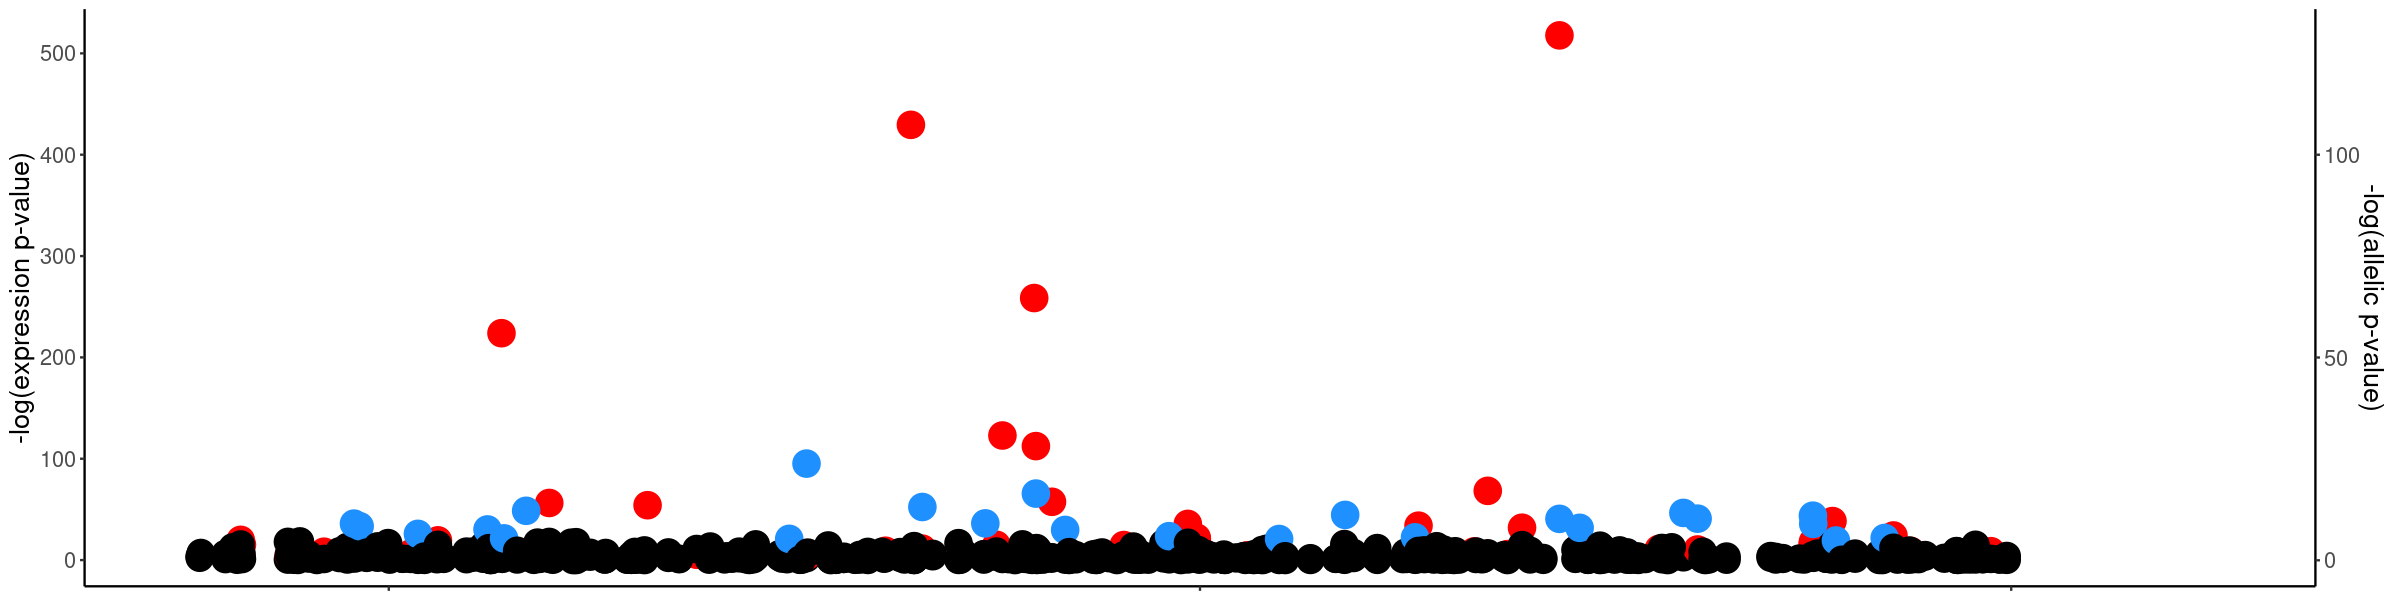

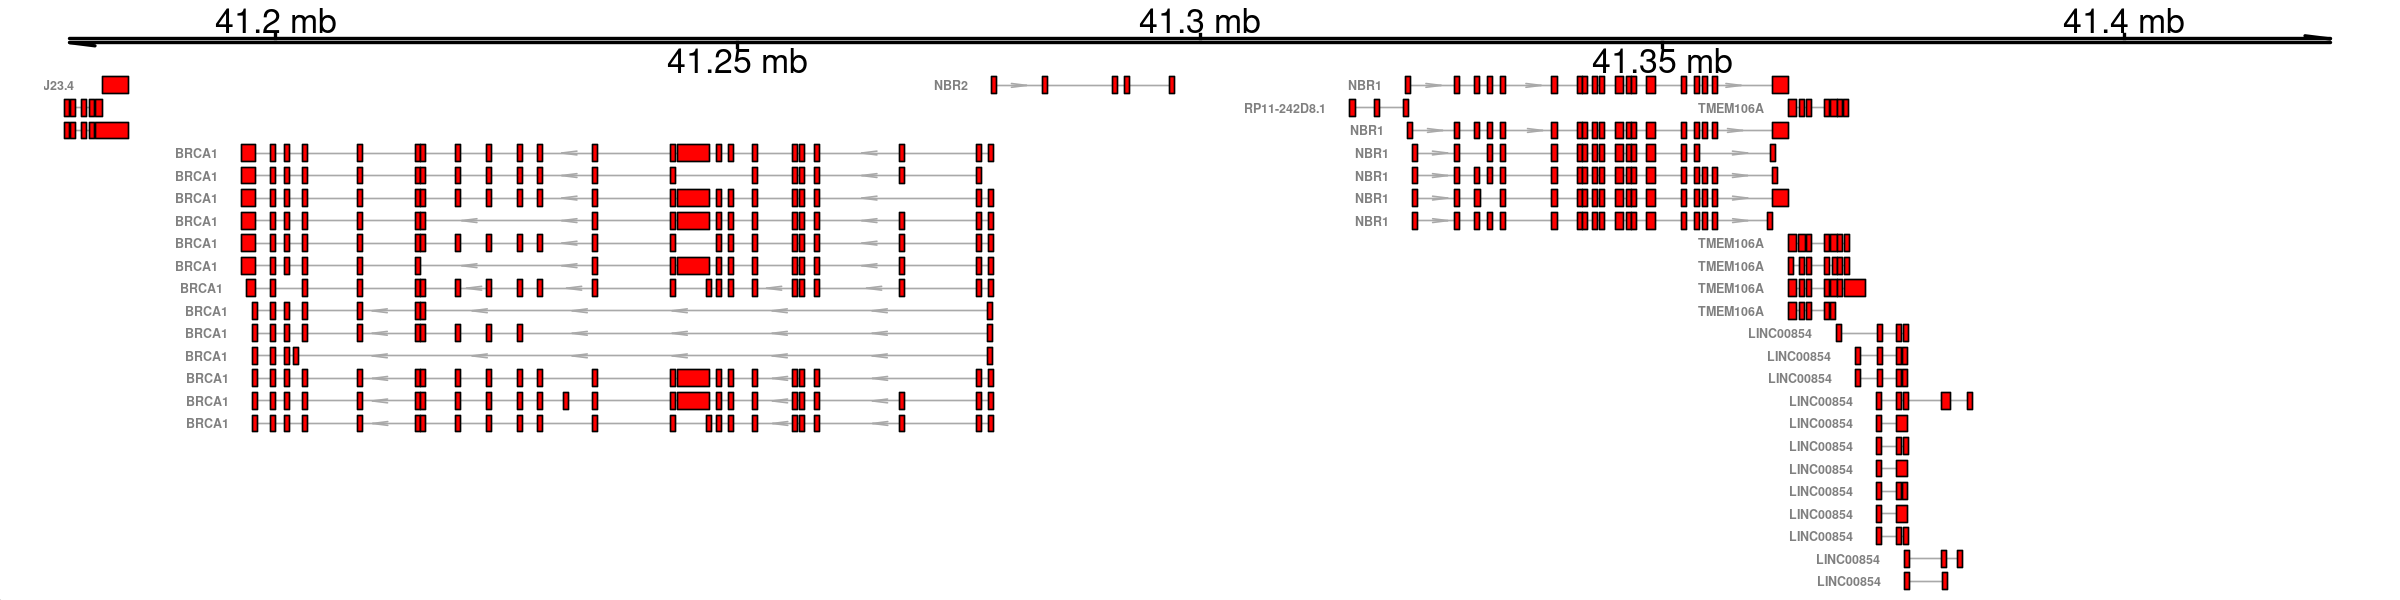

In [29]:
options(repr.plot.width = 20, repr.plot.height = 5)
coeff = 0.25

#pdf("Figure1E.pdf",width = 20, height = 5, useDingbats = F)

ggplot(subset(love, geneID == "ENSG00000012048"),aes(x = as.numeric(pos), label = chromPos)) + 
    geom_point(aes(y = -log(pvalue_expr), color = ifelse(pvalue_expr < 0.01,'red','black')),size = 7) +
    geom_point(aes(y = -log(psvalue_allele)/coeff, color = ifelse(pvalue_allele < 0.01,'dodgerblue','black')),size = 7) +
    theme_classic() +
        theme(text = element_text(size = 16), axis.text.x = element_blank(), axis.title.x = element_blank()) +
    #geom_label_repel(data = subset(love, geneID == "ENSG00000012048" & -log(pvalue_expr) > 100), size = 6, point.padding = 2) +
    scale_x_continuous(limits = c(41175000,41425000), breaks = c(41200000,41300000,41400000)) + scale_color_identity() +
    scale_y_continuous(name = "-log(expression p-value)",sec.axis = sec_axis(~.*coeff, name="-log(allelic p-value)")
  )

plotTracks(list(axTrack, knownGenes), 
           from = from, to = to, showTitle = FALSE,fill="red",fontcolor = "black", showId = TRUE)

#dev.off()

In [30]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/libopenblas-r0.3.3.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] Gviz_1.30.3          GenomicRanges_1.38.0 GenomeInfoDb_1.22.1 
 [4] IRanges_2.20.2       S4Vectors_0.24.4     BiocGenerics_0.32.0 
 [7] scales_1.1.1         data.table_1.13.2    ggrepel_0.8.2       
[10] patchwork_1.1.0      ggpubr_0.4.0         GGally_2.0.0        
[13] forcats_0.5.0        s